<a href="https://colab.research.google.com/github/donbcolab/AIE3/blob/main/paligemma_fine_tune_vqav2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PaliGemma Fine-tuning

In this notebook, we will fine-tune the [pretrained PaliGemma model](https://huggingface.co/google/paligemma-3b-pt-448) on a small subset of the [VQAv2](https://huggingface.co/datasets/HuggingFaceM4/VQAv2) dataset. Let's start by installing the necessary libraries.

In [ ]:
!pip install -q -U git+https://github.com/huggingface/transformers.git datasets accelerate bitsandbytes peft torch

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 76.3 MB/s eta 0:00:00


### Authentication

Authenticate to access the model using `notebook_login()`.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()


### Load Dataset

Next, we load the VQAv2 dataset.

In [ ]:
from datasets import load_dataset
import pandas as pd
from IPython.display import display

# Load the dataset with trust_remote_code
ds = load_dataset('HuggingFaceM4/VQAv2', split="train[:10%]", trust_remote_code=True)

Repo card metadata block was not found. Setting CardData to empty.


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating testdev split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
# Remove unnecessary columns
cols_remove = ["question_type", "answers", "answer_type", "image_id", "question_id"]
ds = ds.remove_columns(cols_remove)

In [ ]:
# Split dataset for training and testing
split_ds = ds.train_test_split(test_size=0.05) # using a small split for demonstration
train_ds = split_ds["train"]
test_ds = split_ds["test"]

In [ ]:
# Display metadata of the training dataset, including feature names and number of rows
print("Train Dataset Metadata:")
print(train_ds)

Train Dataset Metadata:
Dataset({
    features: ['multiple_choice_answer', 'question', 'image'],
    num_rows: 42157
})


In [ ]:
# Display metadata of the testing dataset, including feature names and number of rows
print("Train Dataset Metadata:")
print(test_ds)

Train Dataset Metadata:
Dataset({
    features: ['multiple_choice_answer', 'question', 'image'],
    num_rows: 2219
})


In [ ]:
# Display the first 5 rows using select
def display_sample(dataset, num_samples=5):
    sample = dataset.select(range(num_samples))
    return sample

# Display samples from train and test splits
train_sample = display_sample(train_ds)
test_sample = display_sample(test_ds)

# Convert to DataFrame and display in a grid format
train_sample_df = pd.DataFrame(train_sample)
test_sample_df = pd.DataFrame(test_sample)

print("Train Sample:")
display(train_sample_df)

print("\nTest Sample:")
display(test_sample_df)

Train Sample:


,multiple_choice_answer,question,image
0,beach,What land feature is this?,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,no,Is the person skiing asian?,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,friar,What character is portrayed in the red robe?,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,no,Is this the latest make and model?,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,no,Is this man a novice?,<PIL.JpegImagePlugin.JpegImageFile image mode=...



Test Sample:


,multiple_choice_answer,question,image
0,teddy,What is the bear called?,<PIL.JpegImagePlugin.JpegImageFile image mode=...
1,2,How many computers are on the desk?,<PIL.JpegImagePlugin.JpegImageFile image mode=...
2,2,How many remotes are pictured?,<PIL.JpegImagePlugin.JpegImageFile image mode=...
3,no,Is the light green?,<PIL.JpegImagePlugin.JpegImageFile image mode=...
4,meat,Is the main food a crop or meat?,<PIL.JpegImagePlugin.JpegImageFile image mode=...


### Load Processor

Load the PaliGemma processor to preprocess the dataset.

In [ ]:
from transformers import PaliGemmaProcessor
model_id = "google/paligemma-3b-pt-224"
processor = PaliGemmaProcessor.from_pretrained(model_id)

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

### Preprocess Data

Preprocess the examples by preparing a prompt template and passing the text input along with batches of images to the processor. Set the pad tokens and image tokens to -100 to let the model ignore them. Pass the preprocessed input as labels to train the model.

In [ ]:
import torch
device = "cuda"

image_token = processor.tokenizer.convert_tokens_to_ids("<image>")
def collate_fn(examples):
  texts = ["answer " + example["question"] for example in examples]
  labels= [example['multiple_choice_answer'] for example in examples]
  images = [example["image"].convert("RGB") for example in examples]
  tokens = processor(text=texts, images=images, suffix=labels,
                    return_tensors="pt", padding="longest",
                    tokenize_newline_separately=False)

  tokens = tokens.to(torch.bfloat16).to(device)
  return tokens


### Model Preparation

Since our dataset is general and similar to those PaliGemma was trained with, we do not need to fine-tune the image encoder or the multimodal projector. We will only fine-tune the text decoder.

### Alternative Fine-tuning: LoRA and QLoRA

For LoRA and QLoRA fine-tuning, load the adapter in either full precision or quantized mode.

In [ ]:
from transformers import PaliGemmaForConditionalGeneration, BitsAndBytesConfig
import torch
from peft import get_peft_model, LoraConfig

bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_type=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
#trainable params: 11,298,816 || all params: 2,934,634,224 || trainable%: 0.38501616002417344


Unused kwargs: ['bnb_4bit_compute_type']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


### Training Arguments

Initialize the `TrainingArguments` for the training process.

In [ ]:
# Subset the training dataset
small_train_ds = train_ds.select(range(1000))  # Select first 100 samples for training
small_eval_ds = test_ds.select(range(200))  # Select first 20 samples for evaluation


In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    num_train_epochs=1,  # Reduced to 1 for quicker demonstration
    remove_unused_columns=False,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,  # Reduced to speed up training
    warmup_steps=2,
    learning_rate=2e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=50,  # More frequent logging
    optim="adamw_hf",
    save_strategy="epoch",  # Set to epoch to match evaluation strategy
    push_to_hub=False,  # Disable pushing to hub for this demo
    output_dir="paligemma_vqav2",
    bf16=True,
    report_to=["tensorboard"],
    dataloader_pin_memory=False,
    load_best_model_at_end=True,  # Required for EarlyStoppingCallback
    evaluation_strategy="epoch",  # Set to epoch for periodic evaluation
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1483: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Start Training

Now, we can start the training process.

In [ ]:
from transformers import Trainer, EarlyStoppingCallback

# Define EarlyStoppingCallback
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=1,
    early_stopping_threshold=0.01,
)

# Define Trainer with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=small_train_ds,
    eval_dataset=small_eval_ds,
    data_collator=collate_fn,
    callbacks=[early_stopping]
)


In [ ]:
# Start fine-tuning
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.682000,0.836615


TrainOutput(global_step=125, training_loss=0.6762888488769532, metrics={'train_runtime': 324.1774, 'train_samples_per_second': 3.085, 'train_steps_per_second': 0.386, 'total_flos': 3911382356904576.0, 'train_loss': 0.6762888488769532, 'epoch': 1.0})

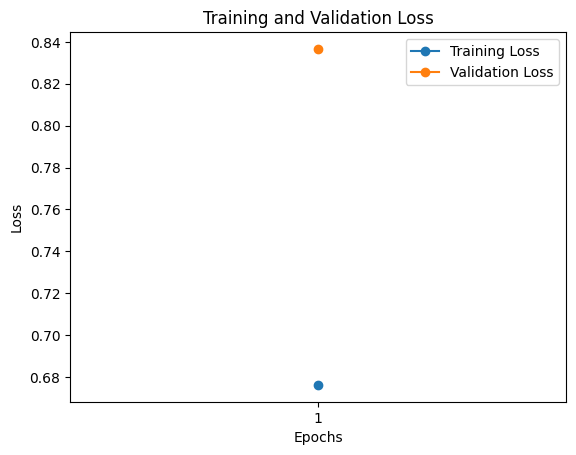

In [ ]:
import matplotlib.pyplot as plt

# Initialize the loss values based on your training output
training_loss = [0.6762888488769532]  # Replace with actual training loss values if you have more epochs
validation_loss = [0.836615]  # Replace with actual validation loss values if you have more epochs

# Define epochs based on the length of the loss lists
epochs = range(1, len(training_loss) + 1)

# Plot the training and validation loss
plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-axis ticks to be the epochs
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


The parameters `target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"]` specify the names of the modules within a transformer model that will be targeted for parameter-efficient fine-tuning using LoRA (Low-Rank Adaptation).

### Explanation of Target Modules

1. **q_proj (Query Projection)**:
   - This module is responsible for transforming the input tokens into query vectors in the self-attention mechanism. Queries are used to calculate attention scores, determining how much focus to give to different parts of the input sequence.

2. **k_proj (Key Projection)**:
   - This module transforms input tokens into key vectors in the self-attention mechanism. Keys, along with queries, are used to compute the attention scores.

3. **v_proj (Value Projection)**:
   - This module transforms input tokens into value vectors in the self-attention mechanism. Values are the actual data that is combined based on the attention scores to produce the output of the attention mechanism.

4. **o_proj (Output Projection)**:
   - This module transforms the output of the attention mechanism into the final representation used for further processing in the model. It combines the attended values from the attention mechanism into a single output.

5. **gate_proj (Gating Projection)**:
   - This module often refers to mechanisms that control the flow of information within the model. Gating mechanisms can be used to dynamically adjust the contribution of different parts of the model based on the input data.

6. **up_proj (Up Projection)**:
   - This module typically refers to a projection that increases the dimensionality of the data. It's used in various places in the model, including in feed-forward networks or other transformation layers.

7. **down_proj (Down Projection)**:
   - This module typically refers to a projection that decreases the dimensionality of the data. It can be used to reduce the size of representations after processing, helping to manage the model’s complexity and computational requirements.

### Purpose in LoRA

In the context of LoRA, targeting these specific modules means that the low-rank adaptation will be applied only to these components of the model. This selective fine-tuning allows for efficient training by focusing on the most impactful parts of the model, thus significantly reducing the number of trainable parameters while maintaining performance.

### Practical Benefits

1. **Efficiency**:
   - By focusing on key projections and transformations, LoRA can achieve significant reductions in computational cost and memory usage.

2. **Performance**:
   - Targeting essential components like query, key, value, and output projections ensures that the fine-tuning process directly impacts the model's core capabilities, preserving or even enhancing performance.

3. **Scalability**:
   - This approach is particularly beneficial when dealing with very large models, where full fine-tuning would be impractical due to resource constraints.

### References

- [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685): This paper introduces the concept of LoRA and explains the targeted fine-tuning approach in detail.
- [Hugging Face Transformers Documentation](https://huggingface.co/docs/transformers/index): The official documentation provides insights into various model components and their roles in transformer architectures.